In [14]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
#from Eigen_decomp import Eigen_decomp
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSSS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib


/Users/hsinyangchen/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[3]) created by __init__ at <ipython-input-2-c8d513a5964f>:14 

In [20]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TOBS','USC00081356')
print Query
df = sqlContext.sql(Query)
print df.count(),'rows'
df.show(df.count())
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

12107
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      3.0| 29.8667| -84.6667|       TMAX|USC00081356|     3|[C8 5A E0 54 40 5...|1900.0|BSBSSSSS|
|      3.0| 29.8667| -84.6667|       TMAX|USC00081356|    11|[90 59 40 5A 60 5...|1901.0|BSBSSSSS|
|      3.0| 29.8667| -84.6667|       TMAX|USC00081356|     5|[28 58 E0 58 60 5...|1902.0|BSBSSSSS|
|      3.0| 29.8667| -84.6667|       TMAX|USC00081356|    34|[20 5B 10 5A 98 5...|1903.0|BSBSSSSS|
|      3.0| 29.8667| -84.6667|       TMAX|USC00081356|    31|[E8 59 C8 5A E8 5...|1904.0|BSBSSSSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows

SELECT * FROM weather
	WHERE measurement='TOBS' and station='USC00081356'
62 r

(62, 365)

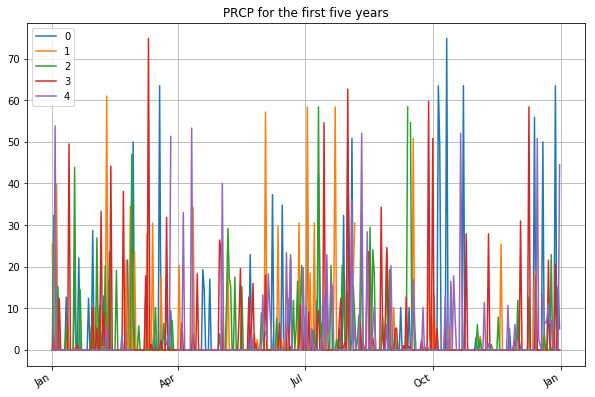

In [5]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:5,:].transpose(),fig,ax,title='PRCP for the first five years')
#title('A sample of graphs');

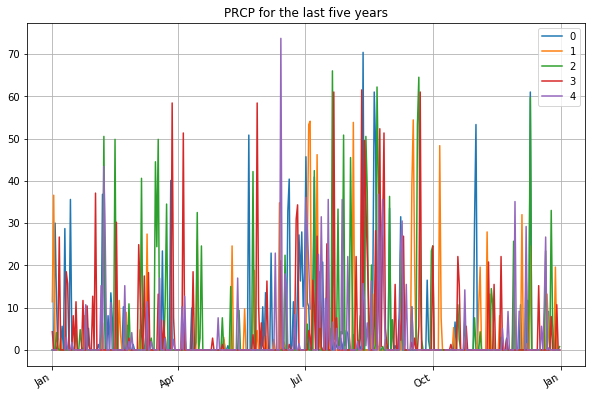

In [70]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[-5:,:].transpose(),fig,ax,title='PRCP for the last five years')
#title('A sample of graphs');

In [6]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)

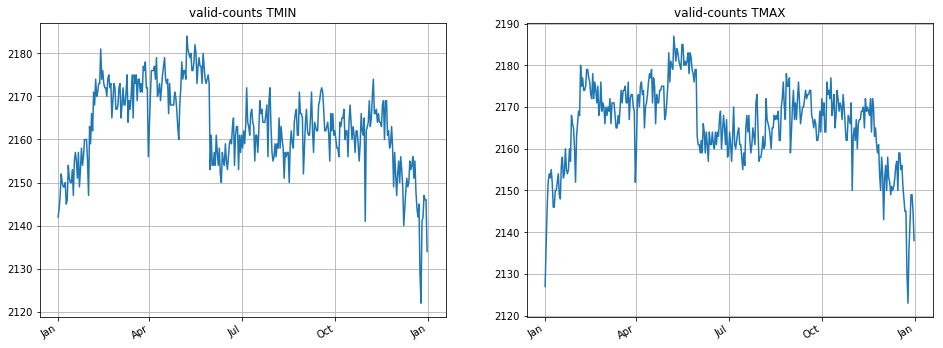

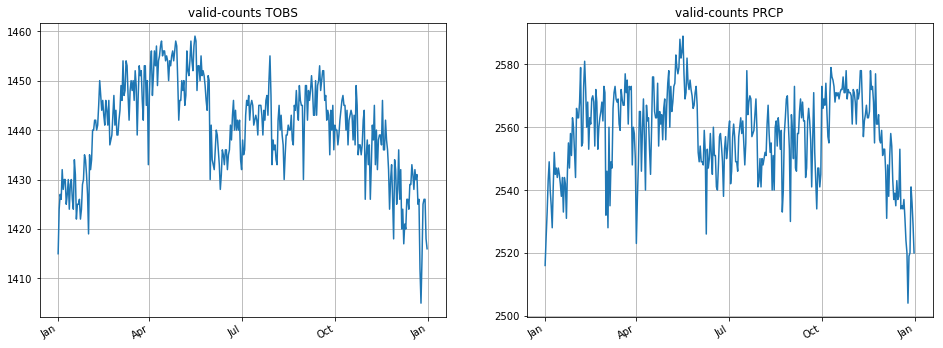

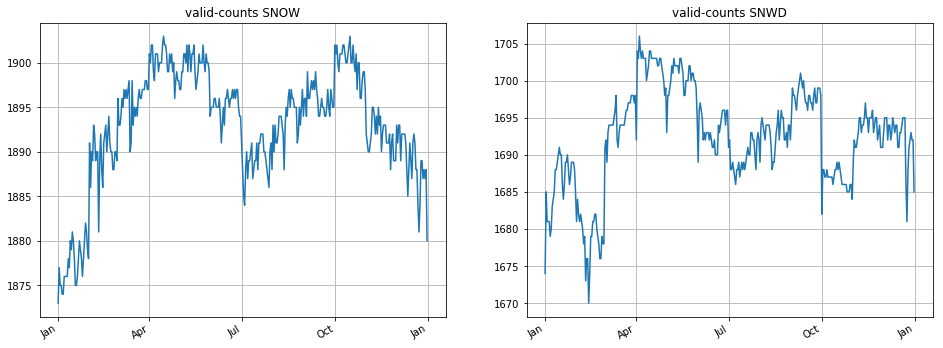

In [19]:
plot_pair(['TMIN','TMAX'],plot_valid)
plot_pair(['TOBS','PRCP'],plot_valid)
plot_pair(['SNOW', 'SNWD'],plot_valid)

In [23]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']/10
    std=np.sqrt(STAT[m]['Var'])/10
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

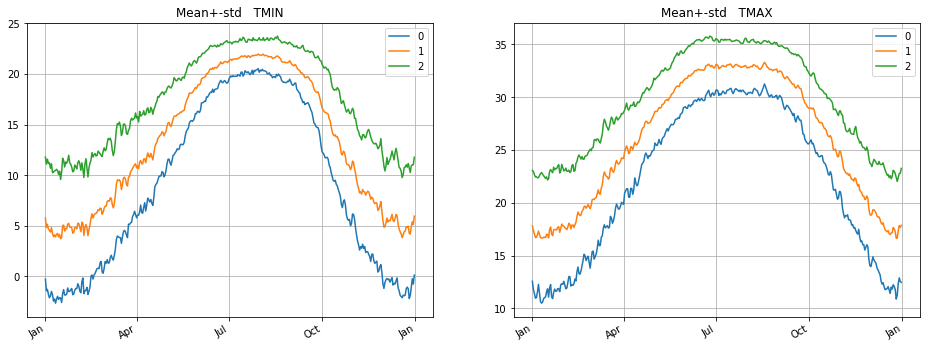

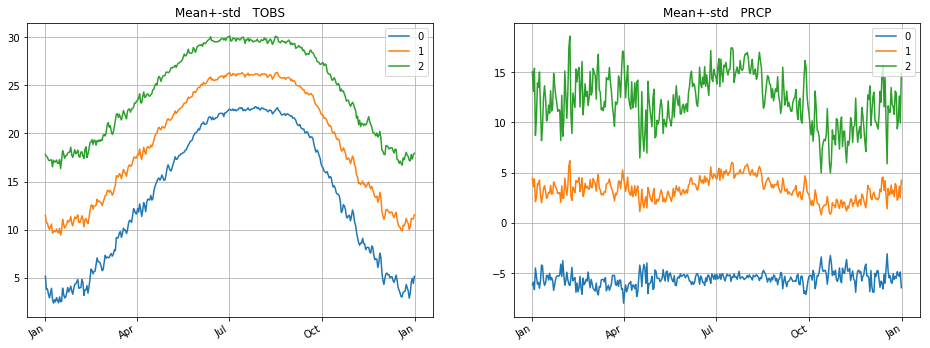

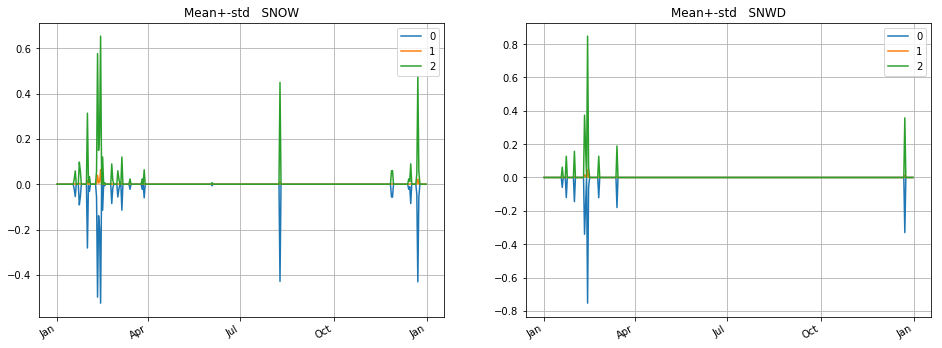

In [24]:
plot_pair(['TMIN','TMAX'],plot_mean_std)
plot_pair(['TOBS','PRCP'],plot_mean_std)
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

In [22]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

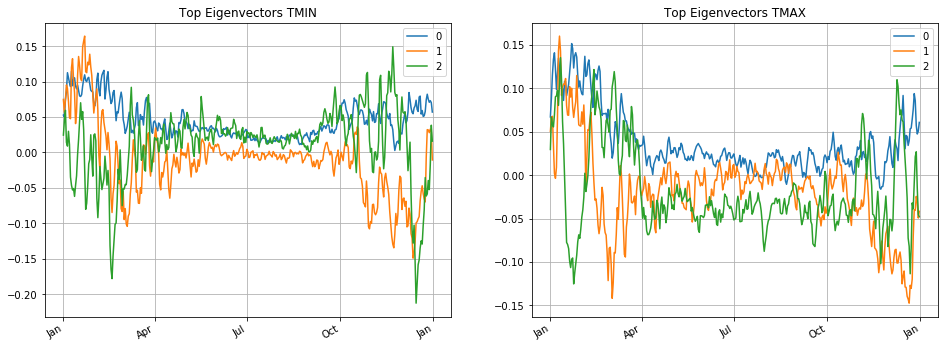

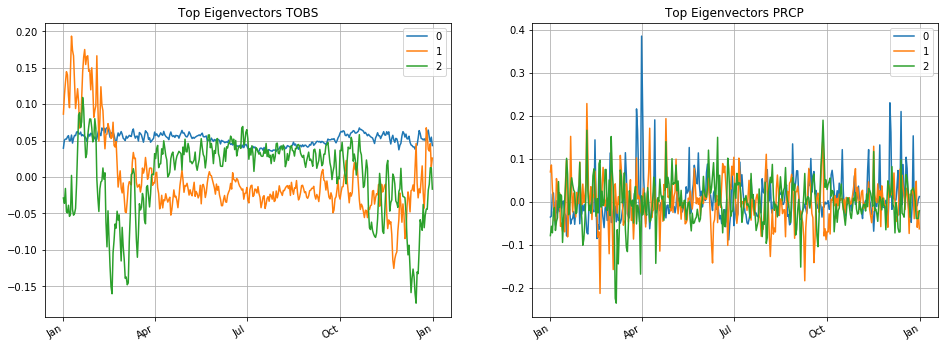

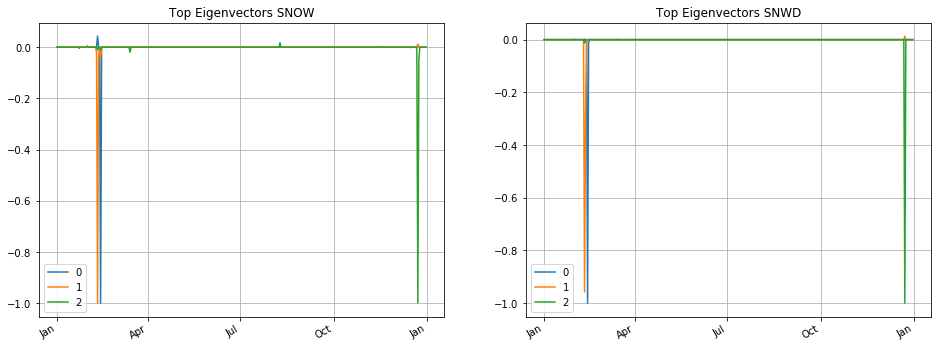

In [24]:
plot_pair(['TMIN','TMAX'],plot_eigen)
plot_pair(['TOBS','PRCP'],plot_eigen)
plot_pair(['SNOW','SNWD'],plot_eigen)

In [25]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()

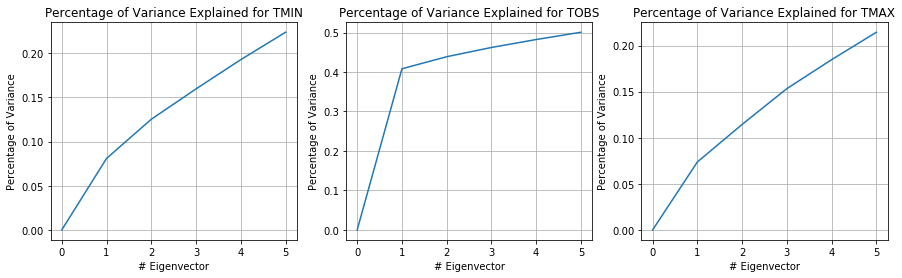

In [27]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

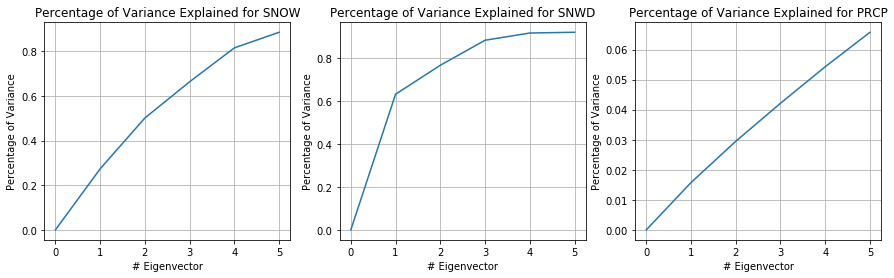

In [28]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [71]:
df=sqlContext.read.parquet(filename)
print df.count()
df=df.filter(df.measurement=='TOBS')
print df.count()
df.show(5)

12107
1473
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      3.0| 29.8667| -84.6667|       TOBS|USC00081356|    16|[40 56 B0 58 B0 5...|1902.0|BSBSSSSS|
|      3.0| 29.8667| -84.6667|       TOBS|USC00081356|     8|[38 59 10 5A 28 5...|1903.0|BSBSSSSS|
|      3.0| 29.8667| -84.6667|       TOBS|USC00081356|     0|[28 58 00 58 80 5...|1905.0|BSBSSSSS|
|      3.0| 29.8667| -84.6667|       TOBS|USC00081356|    31|[00 7E 00 7E 00 7...|1907.0|BSBSSSSS|
|      3.0| 29.8667| -84.6667|       TOBS|USC00081356|     0|[08 59 E0 58 80 4...|1911.0|BSBSSSSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows

